# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 02/20/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GP_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - CFS_EVAP_forecasts_Avgs_MM.csv
    - CFS_PCP_forecasts_Avgs_MM.csv
    - CFS_TMP_forecasts_Avgs_K.csv

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [34]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/ljob/Desktop/'

# Path to download data to
dir = path_to_repo + 'cnbs-predictor/data/'

# Read in the CSVs
tmp_csv = dir + 'CFS_TMP_forecasts_Avgs_K.csv'
evap_csv = dir + 'CFS_EVAP_forecasts_Avgs_MM.csv'
pcp_csv = dir + 'CFS_PCP_forecasts_Avgs_MM.csv'

# Open the trained model(s)
GP_model = joblib.load(dir + 'input/GP_trained_model.joblib')
LR_model = joblib.load(dir + 'input/LR_trained_model.joblib')
RF_model = joblib.load(dir + 'input/RF_trained_model.joblib')
NN_model = joblib.load(dir + 'input/NN_trained_model.joblib')

# Open scalers
x_scaler = joblib.load(dir + 'input/x_scaler.joblib')
y_scaler = joblib.load(dir + 'input/y_scaler.joblib')

# Define Functions

Calculate the number of seconds in a month based on the month and the year. This is used to calculate units between cms and mm.

In [35]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

Convert a dataframe in [cms] to [mm].

In [36]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_mm[column] = df_mm[column] / sa_eri * df_mm['seconds'] * 1000
        elif column.startswith("sup"):
            df_mm[column] = df_mm[column] / sa_sup * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mih * df_mm['seconds'] * 1000
        elif column.startswith("ont"):
            df_mm[column] = df_mm[column] / sa_ont * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

In [37]:
def convert_mm_to_cms(df_mm):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_cms = df_mm.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_cms['seconds'] = df_cms.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_mm / 1000 [to convert to m] * surface_area / seconds_in_a_month
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_eri) / df_cms['seconds']
        elif column.startswith("sup"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_sup) / df_cms['seconds']
        elif column.startswith("mih"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_mih) / df_cms['seconds']
        elif column.startswith("ont"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_ont) / df_cms['seconds']

    # Deleting column 'seconds'
    df_cms.drop('seconds', axis=1)

    return df_cms

In [27]:
def format_predictions(y_pred_scaled, y_scaler):
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    # Convert to dataframe and add column names
    df_y_pred = pd.DataFrame(y_pred, columns=['sup_evap', 'sup_pcp', 'sup_rnoff',
                                              'eri_evap', 'eri_pcp', 'eri_rnoff',
                                              'ont_evap', 'ont_pcp', 'ont_rnoff',
                                              'mih_evap', 'mih_pcp', 'mih_rnoff'])
    # Add back the columns with cfs_run, forecast_year, forecast_month
    df_y_pred[['cfs_run', 'year', 'month']] = pcp_data[['cfs_run', 'forecast_year', 'forecast_month']].astype(int)

    # Calculate CNBS for all the lakes
    for lake in ['sup', 'eri', 'ont', 'mih']:
        df_y_pred[f'{lake}_cnbs'] = df_y_pred[f'{lake}_pcp'] + df_y_pred[f'{lake}_rnoff'] - df_y_pred[f'{lake}_evap']

    # Reorder the columns to move 'year' and 'month' to the left
    df_y_pred = df_y_pred[['cfs_run', 'year', 'month'] + [col for col in df_y_pred.columns if col not in {'cfs_run', 'year', 'month'}]]

    return df_y_pred

In [28]:
def filter_predictions(df_y_pred):
    current_day = datetime.now().day
    current_month = datetime.now().month
    current_year = datetime.now().year

    # Determine filtering condition based on the day of the month
    if current_day >= 26:
        # Remove this month and all previous months
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
        ]
        print(f"First month forecast: {current_month+1}")
    else:
        # Keep this month
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
        ]
        print(f"First month forecast: {current_month}")
    return filtered_y_pred

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [38]:
## Read in PCP data from CFSR [mm]
pcp_data = pd.read_csv(pcp_csv,sep=',')

## Read in EVAP data from CFSR [mm]
evap_data = pd.read_csv(evap_csv,sep=',')

## Read in TMP data from CFSR [K]
tmp_data = pd.read_csv(tmp_csv,sep=',')

In [39]:
X = pd.DataFrame({
    'sup_pcp_w': pcp_data['sup_lake'],
    'eri_pcp_w': pcp_data['eri_lake'],
    'ont_pcp_w': pcp_data['ont_lake'],
    'mih_pcp_w': pcp_data['mih_lake'],
    'sup_pcp_l': pcp_data['sup_land'],
    'eri_pcp_l': pcp_data['eri_land'],
    'ont_pcp_l': pcp_data['ont_land'],
    'mih_pcp_l': pcp_data['mih_land'],
    'sup_evap_w': evap_data['sup_lake'],
    'eri_evap_w': evap_data['eri_lake'],
    'ont_evap_w': evap_data['ont_lake'],
    'mih_evap_w': evap_data['mih_lake'],
    'sup_evap_l': evap_data['sup_land'],
    'eri_evap_l': evap_data['eri_land'],
    'ont_evap_l': evap_data['ont_land'],
    'mih_evap_l': evap_data['mih_land'],
    'sup_tmp_w': tmp_data['sup_lake'],
    'eri_tmp_w': tmp_data['eri_lake'],
    'ont_tmp_w': tmp_data['ont_lake'],
    'mih_tmp_w': tmp_data['mih_lake'],
    'sup_tmp_l': tmp_data['sup_land'],
    'eri_tmp_l': tmp_data['eri_land'],
    'ont_tmp_l': tmp_data['ont_land'],
    'mih_tmp_l': tmp_data['mih_land']
})

Standardize the data

In [40]:
# Standardize the data
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [ ]:
y_filtered_model = {}

# List of models and their corresponding names
model_dict = {
    'GP': GP_model,
    'LR': LR_model,
    'RF': RF_model,
    'NN': NN_model
}

# Loop through each model and process the predictions
for model_name, model in model_dict.items():
    # Step 1: Predict scaled values
    y_pred_scaled = model.predict(X_scaled)

    # Step 2: Format the predictions
    y_pred = format_predictions(y_pred_scaled, y_scaler)

    # Step 3: Filter predictions
    y_filtered = filter_predictions(y_pred)
    y_filtered_model[model_name] = pd.DataFrame(y_filtered)

    # Step 4: Save ensemble predictions for each model as CSV in [mm]
    #y_filtered.to_csv(f'{dir}CNBS_forecasts_mm_{model_name}.csv', sep=',', index=False)

    # Step 5: Convert mm to cms
    df_y_cms = convert_mm_to_cms(y_filtered)

    # Step 6: Save ensemble predictions for each model as CSV in [cms]
    #df_y_cms.to_csv(f'{dir}CNBS_forecasts_cms_{model_name}.csv', sep=',', index=False)

First month forecast: 3
First month forecast: 3
First month forecast: 3
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
First month forecast: 3


In [43]:
models = ['GP', 'LR', 'RF', 'NN']

# List of datasets
datasets = [y_filtered_model[model] for model in models]

# Combine all datasets and group by 'year' and 'month' to calculate median
combined_dataset = pd.concat(datasets)

In [ ]:
# Calculate the median forecast value for each month from the entire ensemble
median_dataset = combined_dataset.groupby(['year', 'month']).median().reset_index()

# Save to a CSV [mm]
median_dataset.to_csv(f'{dir}forecast/CNBS_forecast_mm.csv', sep=',', index=False)

# Convert mm to cms
median_cms = convert_mm_to_cms(median_dataset)

# Save to a CSV [cms]
median_cms.to_csv(f'{dir}forecast/CNBS_forecast_cms.csv', sep=',', index=False)

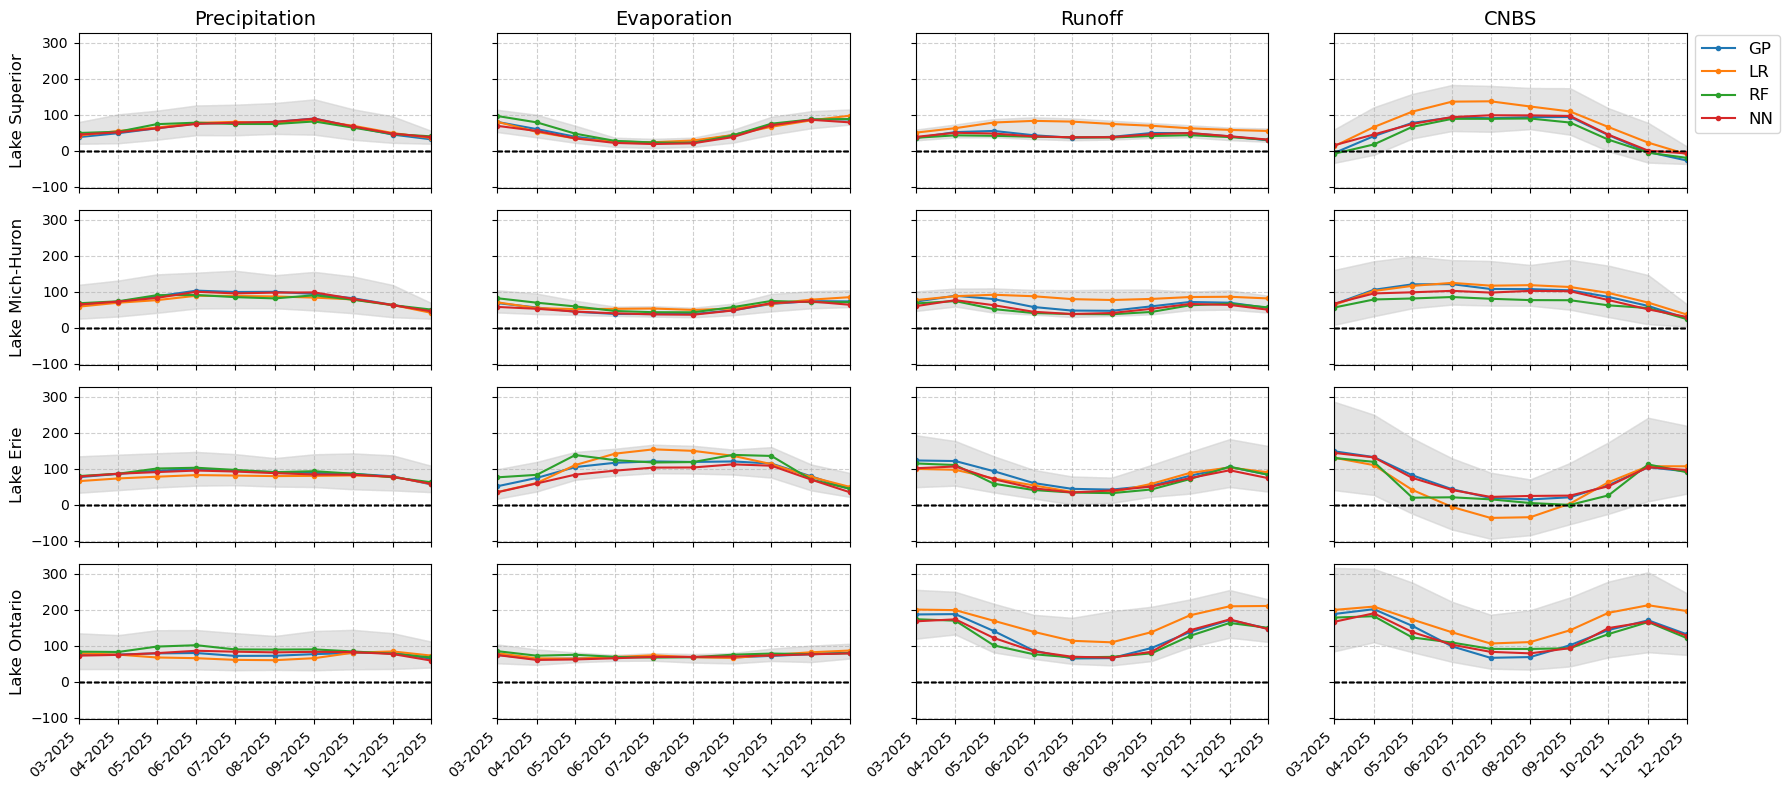

In [ ]:
# Columns of interest
columns = ['sup_pcp', 'sup_evap', 'sup_rnoff', 'sup_cnbs',
           'mih_pcp', 'mih_evap', 'mih_rnoff', 'mih_cnbs',
           'eri_pcp', 'eri_evap', 'eri_rnoff', 'eri_cnbs',
           'ont_pcp', 'ont_evap', 'ont_rnoff', 'ont_cnbs']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(18, 8))

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes

# Group data by 'year' and 'month' once for each dataset
grouped_datasets = {
    model: dataset.groupby(['year', 'month']).median().reset_index()
    for model, dataset in zip(models, datasets)
}

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for dataset_index, model in enumerate(models):
        # Get the grouped DataFrame for the current model
        median_df = grouped_datasets[model]

        # Add a 'date' column to the median DataFrame
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize=3, label=model)

        # Add the shaded region (confidence band)
        axs[row, col].fill_between(median_df['date'], lower_bound[column], upper_bound[column], color='lightgray', alpha=0.2)
        axs[row, col].axhline(0, color='black', linestyle='--', linewidth=1) # Add a dashed line on 0
        axs[row, col].grid(True, linestyle='--', alpha=0.6) # Turn on a grid
        axs[row, col].set_yticks(np.arange(-1000, 1000, 100)) # Force y ticks on every 100

        # Update the global y-axis limits based on the current dataset
        # This allows us to set a y min and y max that is the same for all of the figures at the end
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set titles based on row and column
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'CNBS'][col], fontsize=14)
    else:
        axs[row, col].set_title('')

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y')) # Format the dates on the x axis
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
        for label in axs[row, col].get_xticklabels(): # Position the labels
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([]) # Turn off x axis labels on all of the plots but the bottom row

    # Set y-axis labels for the first column only
    if col == 0:
        axs[row, col].set_ylabel(['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario'][row], fontsize=12)
    else:
        axs[row, col].set_yticklabels([]) # Turn off titles 

# Set consistent y-axis limits across all subplots
for row in range(4):
    for col in range(4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)
        axs[row, col].set_xlim(median_df['date'].iloc[0], median_df['date'].iloc[-1])

# Position the legend outside the plot area to the right
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3),fontsize=12)

# Save the figure as a PNG file
plt.savefig(f'{dir}forecast/CNBS_forecasts.png')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
